In [1]:
import numpy as np
import re
import pandas as pd
import torch
import torch.autograd
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from scipy.stats.mstats import spearmanr
from sklearn.externals import joblib

from pavooc.scoring.feature_extraction import extract_features, split_test_train_valid, normalize_features
from pavooc.scoring.azimuth_dataset import load_dataset
from pavooc.scoring import models
from pavooc.scoring.helper import run_model, run_models, train_predict_n_shuffles
from pavooc.scoring.training import cv_train_test
from pavooc.config import CONSERVATION_FEATURES_FILE, SCALER_FILE


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
Xdf, Y, gene_position, target_genes = load_dataset()
conservation_scores = pd.read_csv(CONSERVATION_FEATURES_FILE, index_col=0)

combined_features, y, genes, feature_names = extract_features(Xdf, Y, gene_position, conservation_scores, order=1)
normalized_features, scaler = normalize_features(combined_features)
X_train, X_test, y_train, y_test, validation_fold, _ = split_test_train_valid(combined_features, y, joint_scaling=True)

joblib.dump(scaler, SCALER_FILE)

Loaded 149 samples for gene CCDC101 	total number of samples: 149
Loaded 924 samples for gene MED12 	total number of samples: 1073
Loaded 190 samples for gene TADA2B 	total number of samples: 1263
Loaded 109 samples for gene TADA1 	total number of samples: 1372
Loaded 64 samples for gene HPRT1 	total number of samples: 1436
Loaded 154 samples for gene CUL3 	total number of samples: 1590
Loaded 736 samples for gene NF1 	total number of samples: 2326
Loaded 223 samples for gene NF2 	total number of samples: 2549
Loaded 924 samples for gene MED12 	total number of samples: 3473


['/home/giali/pavooc/pavooc/../data/scaler.pkl']

In [3]:

from sklearn.externals import joblib

from pavooc.config import CONSERVATION_FEATURES_FILE, SCALER_FILE
joblib.dump(scaler, SCALER_FILE)

['/home/giali/pavooc/pavooc/../data/scaler.pkl']

In [208]:
len(feature_names)


160

In [209]:
# actually including non-order features as well
order1_features = [not re.match('^[ACTG]{2}(_\d+)?$', feature) for feature in feature_names]
order2_features = [True for feature in feature_names]
without_conservation = [i < 150 for i in range(160)]
# without counts etc..
pure_seq1_features = [bool(re.match('^([ACTG]_\d{1,2})$', feature)) for feature in feature_names]
pure_order1_features = [bool(re.match('^([ACTG]_\d{1,2}|Percent Peptide|Amino Acid Cut position|conservation.*|.*False)$', feature)) for feature in feature_names]
pure_order1_without_conservation_features = [bool(re.match('^([ACTG]_\d{1,2}|Percent Peptide|Amino Acid Cut position|.*False)$', feature)) for feature in feature_names]
order1_without_conservation_features = [not re.match('^([ACTG]{2}(_\d+)?|conservation.*)$', feature) for feature in feature_names]

In [228]:
three_output_wo_conv = train_predict_n_shuffles(CNN38ThreeOutput, 
                                         normalized_features,
                                         order1_features,
                                         y,
                                         7,
                                         0.0003,
                                         15000)

In [231]:
three_output_conv_tvt = three_output_wo_conv

In [275]:
three_output_conv_tvt

([0.61346702908077522,
  0.61512166976365734,
  0.65933156214079303,
  0.63466442403837353,
  0.63685212409392578,
  0.62280554761904272,
  0.66142474915034111],
 [0.63076803757197786,
  0.62596949957819192,
  0.62454597283730806,
  0.61402825570530706,
  0.62543545059673122,
  0.61312367636351983,
  0.63008957981546243],
 [CNN38ThreeOutput(
    (conv1): Conv1d(4, 256, kernel_size=(7,), stride=(1,))
    (conv2): Conv1d(256, 1024, kernel_size=(3,), stride=(1,))
    (pre_fc): Linear(in_features=160, out_features=256, bias=True)
    (fc1): Linear(in_features=2304, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=1, bias=True)
  ), CNN38ThreeOutput(
    (conv1): Conv1d(4, 256, kernel_size=(7,), stride=(1,))
    (conv2): Conv1d(256, 1024, kernel_size=(3,), stride=(1,))
    (pre_fc): Linear(in_features=160, out_features=256, bias=True)
    (fc1): Linear(in_features=2304, out_features=512, bias=True)
   

In [5]:
from pavooc.scoring.models import CNN38

In [ ]:
new_cnn38_results = train_predict_n_shuffles(CNN38ConvSizes, 
                                         normalized_features,
                                         order1_features,
                                         y,
                                         7,
                                         0.0003,
                                         20000)

In [274]:
three_output_wo_conv[1]

[0.63076803757197786,
 0.62596949957819192,
 0.62454597283730806,
 0.61402825570530706,
 0.62543545059673122,
 0.61312367636351983,
 0.63008957981546243]

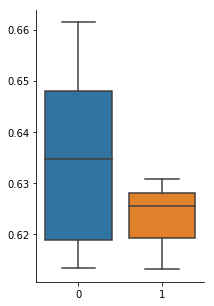

In [233]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 5))
sns.boxplot(data=three_output_wo_conv[:2]) # plot validation scores vs test scores
sns.despine()


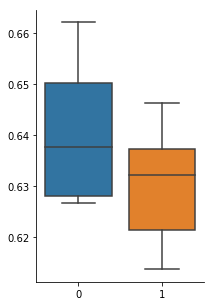

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 5))
sns.boxplot(data=new_cnn38_results[:2]) # plot validation scores vs test scores
sns.despine()


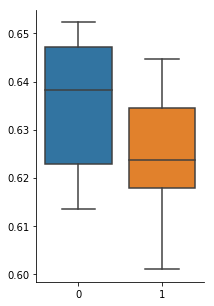

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 5))
sns.boxplot(data=cnn38_results[:2]) # plot validation scores vs test scores
sns.despine()


In [273]:
cnn38_results[:2] # validation scores against test scores. 0.62 is realistic..

([0.65230484183299531,
  0.61445868907343626,
  0.64749130007044486,
  0.64700745128400872,
  0.63104311661558865,
  0.63832404137578791,
  0.61340385343030868],
 [0.6268950518547417,
  0.61607325228121712,
  0.60093018246545093,
  0.64474238583741383,
  0.62358489116443239,
  0.61967470257538948,
  0.64217883637197126])

In [19]:
L = normalized_features.shape[0]
indices = np.random.permutation(L)
num_folds = 5
folds = [np.array([j in indices[(L//5)*i:(L//5)*(i+1)] for j in range(L)]) for i in range(num_folds)]

In [ ]:
cv_spearmans1 = cv_train_test(genes, normalized_features[:, order1_features], y, CNN38ThreeOutput, 0.0003, 15000, folds=folds)
cv_spearmans2 = cv_train_test(genes, normalized_features[:, order1_features], y, CNN38ThreeOutput, 0.0003, 15000, folds=folds)
cv_spearmans3 = cv_train_test(genes, normalized_features[:, order1_features], y, CNN38ThreeOutput, 0.0003, 15000, folds=folds)
cv_spearmans4 = cv_train_test(genes, normalized_features[:, order1_features], y, CNN38ThreeOutput, 0.0003, 15000, folds=folds)


/home/giali/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/giali/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/giali/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/giali/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/giali/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


UnboundLocalError: local variable 'best_model' referenced before assignment

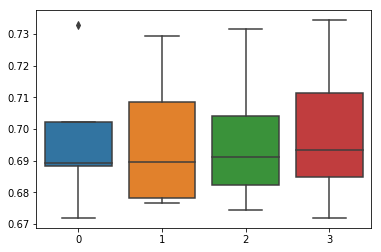

In [183]:
sns.boxplot(data=[cv_spearmans1, cv_spearmans2, cv_spearmans3, cv_spearmans4])

In [271]:
[cv_spearmans1, cv_spearmans2, cv_spearmans3, cv_spearmans4]

[[0.66920040574650641,
  0.68529927893892739,
  0.68474951581807098,
  0.69703600200378135,
  0.71304586917204993],
 [0.66903768545966347,
  0.68206029774039079,
  0.67818732161894946,
  0.68982041947535166,
  0.72334489245317124],
 [0.67434803657727482,
  0.68240897928722721,
  0.6912733721249007,
  0.70404194210553184,
  0.73168843329500566],
 [0.67195702439707561,
  0.68484536165909282,
  0.6935326052878672,
  0.71147790623366858,
  0.73437727228820748]]

In [272]:
new_cnn38_three_output_wo_conv

[0.67484413659638365,
 0.67871418020466001,
 0.68338228303244619,
 0.68867827744571475,
 0.72251520480650078]

In [154]:
cv_spearmans_different_folds_old = cv_spearmans_different_folds

In [ ]:
cv_spearmans_different_folds = []
for i in range(4):
    L = normalized_features.shape[0]
    indices = np.random.permutation(L)
    num_folds = 5
    diff_folds = [np.array([j in indices[(L//5)*i:(L//5)*(i+1)] for j in range(L)]) for i in range(num_folds)]
    
    cv_spearmans_different_folds.append(cv_train_test(genes, normalized_features[:, order1_features], y, CNN38ThreeOutput, 0.0003, 15006 + i, folds=diff_folds))

In [269]:
cv_spearmans_different_folds

[[0.67832291815206247,
  0.68718322928573461,
  0.65971349400976298,
  0.69910848120234126,
  0.71849464182506251],
 [0.70090018649410446,
  0.70132048824092041,
  0.71926775383333108,
  0.69785942113023802,
  0.68719640026774564],
 [0.67700583201354214,
  0.67794561306045675,
  0.68860324893318259,
  0.70296057710380433,
  0.69984678724170113],
 [0.6739727981345649,
  0.6933583000363398,
  0.69181362348793018,
  0.70041536393417669,
  0.68790494567272198]]

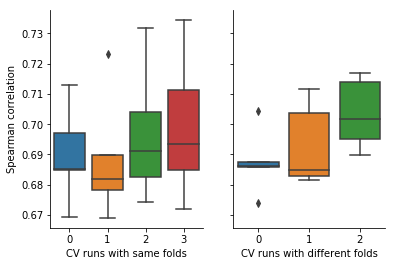

In [226]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

sns.boxplot(data=[cv_spearmans1, cv_spearmans2, cv_spearmans3, cv_spearmans4], ax=ax1)

ax1.set_ylabel('Spearman correlation')
ax1.set_xlabel('CV runs with same folds')
plt.savefig('figures/cnn38_cv_same_folds.png')


sns.boxplot(data=cv_spearmans_different_folds, ax=ax2)
ax2.set_xlabel('CV runs with different folds')

sns.despine()
fig.savefig('figures/cnn38_cv_same_different_folds.png')

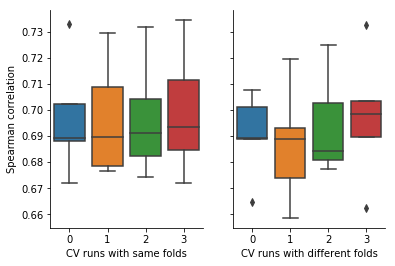

In [187]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

sns.boxplot(data=[cv_spearmans1, cv_spearmans2, cv_spearmans3, cv_spearmans4], ax=ax1)

ax1.set_ylabel('Spearman correlation')
ax1.set_xlabel('CV runs with same folds')
plt.savefig('figures/cnn38_cv_same_folds.png')


sns.boxplot(data=cv_spearmans_different_folds, ax=ax2)
ax2.set_xlabel('CV runs with different folds')

sns.despine()
fig.savefig('figures/cnn38_cv_same_different_folds.png')

In [32]:
from pavooc.scoring.models import weights_init 
from torch import nn
import torch
from torch.nn.init import kaiming_normal, normal
import torch.nn.functional as F

class CNN38OneConv(nn.Module):
    def __init__(self, input_size):
        super(CNN38OneConv, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels=4, out_channels=128, kernel_size=4, stride=1)

        # 128 kernels, 30-3 => 27/2 => 13-3 => 10/2 => 5
        self._conv_output_dimension = 128 * 9

        # hidden layers, additional_features, conv output

        self.pre_fc = nn.Linear(input_size, 256)
        self.fc1 = nn.Linear(256 + self._conv_output_dimension, 32)
        self.fc2 = nn.Linear(32, 1)

        self.apply(weights_init)

    def _forward_convolution(self, nuc_features):

        conv_input = nuc_features.view(-1, 30, 4).permute(0, 2, 1)

        conv1_output = F.relu(self.conv1(conv_input))
        conv1_output = F.dropout(conv1_output, 0.4, self.training)


        conv1_output = F.max_pool1d(conv1_output, 3)
        return conv1_output.view(-1, self._conv_output_dimension)

    def forward(self, x):
        nuc_features = x[:, :120]
        nuc_features.contiguous()

        convolution_output = self._forward_convolution(nuc_features)
        # two fully connected hidden layers

        pre_output = self.pre_fc(x)
        pre_output = F.dropout(pre_output, 0.55, self.training)

        out = F.relu(self.fc1(torch.cat(
            [pre_output, convolution_output], 1)))

        out = F.dropout(out, 0.55, self.training)


        return self.fc2(out)
one_conv_results = cv_train_test(genes, normalized_features[:, order1_features], y, CNN38OneConv, 0.0003, 15001, folds=folds)

In [268]:
one_conv_results


[0.66174671914079108,
 0.68424951934589817,
 0.64784226517384746,
 0.66450566115001608,
 0.68221324542003325]

In [ ]:
class CNN38ThreeConv(nn.Module):
    def __init__(self, input_size):
        super(CNN38ThreeConv, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels=4, out_channels=128, kernel_size=4, stride=1)  # boost this?
        self.conv2 = nn.Conv1d(
            in_channels=128, out_channels=256, kernel_size=2)
        self.conv3 = nn.Conv1d(
            in_channels=256, out_channels=512, kernel_size=3)
        
        # 128 kernels, 30-3 => 27/2 => 13-3 => 10/2 => 5
        self._conv_output_dimension = 512 * 2

        # hidden layers, additional_features, conv output

        self.pre_fc = nn.Linear(input_size, 256)
        self.fc1 = nn.Linear(256 + self._conv_output_dimension, 32)
        self.fc2 = nn.Linear(32, 1)

        self.apply(weights_init)

    def _forward_convolution(self, nuc_features):

        conv_input = nuc_features.view(-1, 30, 4).permute(0, 2, 1)

        conv1_output = F.relu(self.conv1(conv_input))
        conv1_output = F.dropout(conv1_output, 0.4, self.training)


        conv1_output = F.max_pool1d(conv1_output, 2)
        conv2_output = F.relu(self.conv2(conv1_output))
        conv2_output = F.dropout(conv2_output, 0.5, self.training)
        conv2_output = F.max_pool1d(conv2_output, 2)
        
        conv3_output = F.relu(self.conv3(conv2_output))
        conv3_output = F.dropout(conv3_output, 0.5, self.training)
        conv3_output = F.max_pool1d(conv3_output, 2)
        return conv3_output.view(-1, self._conv_output_dimension)

    def forward(self, x):
        nuc_features = x[:, :120]
        nuc_features.contiguous()

        convolution_output = self._forward_convolution(nuc_features)
        # two fully connected hidden layers

        pre_output = self.pre_fc(x)
        pre_output = F.dropout(pre_output, 0.55, self.training)

        out = F.relu(self.fc1(torch.cat(
            [pre_output, convolution_output], 1)))

        out = F.dropout(out, 0.55, self.training)

        return self.fc2(out)
three_conv_results = cv_train_test(genes, normalized_features[:, order1_features], y, CNN38ThreeConv, 0.0003, 15001, folds=folds)


In [267]:
three_conv_results

[0.68666108802791237,
 0.70188352416888733,
 0.65551494647987696,
 0.68076562599838009,
 0.69134121947247351]

In [ ]:
# run 5 "standard" randomized runs. they should perform worse than the cv_train_test. and why?
# TODO rerun!
rand_shuffle_results = train_predict_n_shuffles(CNN38, 
                                                normalized_features,
                                                order1_features,
                                                y,
                                                10,
                                                0.0003,
                                                15000)

# could combine with cnn38_results (7 more runs...). just compare the two to see they are similar

In [ ]:
# TODO azimuth 10 random runs with validation and test
from pavooc.scoring.adaboost import train_predict_adaboost
adaboost_results = train_predict_adaboost(normalized_features, order2_features,  y, num_runs=10)

In [189]:
sns.barplot(data=[azimuth_tests, my_validations, my_tests])  # TODO group the bars together..
sns.despine()
plt.savefig('train_test_comparison.png')

NameError: name 'azimuth_tests' is not defined

In [ ]:
# run gene cv..
gene_cv_results = cv_train_test(genes, normalized_features[:, order1_features], y, CNN38ThreeOutput, 0.0003, 15003)


In [276]:
gene_cv_results

[0.66088393516402366,
 0.63363049880858857,
 0.55256729873334842,
 0.58568693749689238,
 0.57192151055164742,
 0.63046229775978591,
 0.59348020044524352,
 0.55483878324221514,
 0.5401754750187554,
 0.45668782876836572,
 0.4662632512758017,
 0.5319210746289168,
 0.57179130757112406,
 0.65924908424908424,
 0.51208466783712281,
 0.43601654074361196,
 0.42120760254168327]

In [236]:
np.median(gene_cv_results)

0.55483878324221514

In [255]:
# train_predict_n_shuffles performs a lot worse than cv_train_predict. The (only) difference is the number of training samples: 
# While cv_train_predict uses cross validation and can train on 4000 samples for 5 folds, train_predict_n_shuffles uses both a separate validation and test set
# this lowers the number of training samples to 3000. Here I verify, that the model performs significantly worse with 3000 training samples only!

# first parameter is unnecessary when not running gene-cv
cv_results_3000 = []
for i in range(4):
    L = 4000    
    indices5000 = np.random.permutation(normalized_features.shape[0])[:L]
    indices = np.random.permutation(L)
    num_folds = 4
    folds_4000 = [np.array([j in indices[(L//num_folds)*i:(L//num_folds)*(i+1)] for j in range(L)]) for i in range(num_folds)]

    cv_results_3000.append(cv_train_test(pd.Series([]), normalized_features[indices5000.reshape([-1, 1]), order1_features], y[indices5000], CNN38ThreeOutput, 0.0003, 15005, folds=folds_4000))

In [266]:
cv_results_3000

[[0.61468879912581287,
  0.64243973979097391,
  0.66791851097287402,
  0.63880063318685443],
 [0.61159737003391035,
  0.67535353121949115,
  0.63880128773680822,
  0.69325398363305302],
 [0.62504748841458857,
  0.66087102603815007,
  0.64801293043361896,
  0.61546255991194931],
 [0.64428576494776069,
  0.64516132942052629,
  0.59467782602075436,
  0.64669403059891239]]

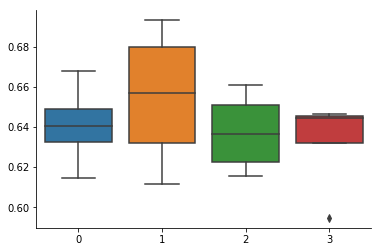

In [259]:
sns.boxplot(data=cv_results_3000)
sns.despine()
plt.savefig('figures/cnn38_4000_cv.png')

In [132]:
class CNN38ConvSizes(nn.Module):  # TODO swap names with CNN38
    def __init__(self, input_size):
        super(CNN38ConvSizes, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels=4, out_channels=256, kernel_size=7, stride=1)  # boost this?
        self.conv2 = nn.Conv1d(
            in_channels=256, out_channels=1024, kernel_size=3)
        
        # 128 kernels, 30-3 => 27/2 => 13-3 => 10/2 => 5
        self._conv_output_dimension = 1024 * 2

        # hidden layers, additional_features, conv output

        self.pre_fc = nn.Linear(input_size, 256)
        self.fc1 = nn.Linear(256 + self._conv_output_dimension, 32)
        self.fc2 = nn.Linear(32, 1)

        self.apply(weights_init)

    def _forward_convolution(self, nuc_features):

        conv_input = nuc_features.view(-1, 30, 4).permute(0, 2, 1)

        conv1_output = F.relu(self.conv1(conv_input))
        conv1_output = F.dropout(conv1_output, 0.4, self.training)


        conv1_output = F.max_pool1d(conv1_output, 3)
        conv2_output = F.relu(self.conv2(conv1_output))
        conv2_output = F.dropout(conv2_output, 0.5, self.training)
        conv2_output = F.max_pool1d(conv2_output, 3)
        

        return conv2_output.view(-1, self._conv_output_dimension)

    def forward(self, x):
        nuc_features = x[:, :120]
        nuc_features.contiguous()

        convolution_output = self._forward_convolution(nuc_features)
        # two fully connected hidden layers

        pre_output = self.pre_fc(x)
        pre_output = F.dropout(pre_output, 0.55, self.training)

        out = F.relu(self.fc1(torch.cat(
            [pre_output, convolution_output], 1)))

        out = F.dropout(out, 0.55, self.training)

        return self.fc2(out)


In [ ]:
sizes_conv_results = cv_train_test(genes, normalized_features[:, order1_features], y, CNN38ConvSizes, 0.0003, 15002, folds=folds)

In [190]:
sizes_conv_results

[0.67306788506340243,
 0.67820428630812268,
 0.68452475472631436,
 0.70844064069131729,
 0.72691381636930841]

In [ ]:
class CNN38NoPreproc(nn.Module):
    def __init__(self, input_size):
        super(CNN38NoPreproc, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels=4, out_channels=256, kernel_size=7, stride=1)  # boost this?
        self.conv2 = nn.Conv1d(
            in_channels=256, out_channels=1024, kernel_size=3)

        # 128 kernels, 30-3 => 27/2 => 13-3 => 10/2 => 5
        self._conv_output_dimension = 1024 * 2

        # hidden layers, additional_features, conv output
        self.fc1 = nn.Linear(input_size + self._conv_output_dimension, 32)
        self.fc2 = nn.Linear(32, 1)

        self.apply(weights_init)

    def _forward_convolution(self, nuc_features):

        conv_input = nuc_features.view(-1, 30, 4).permute(0, 2, 1)

        conv1_output = F.relu(self.conv1(conv_input))
        conv1_output = F.dropout(conv1_output, 0.4, self.training)


        conv1_output = F.max_pool1d(conv1_output, 3)
        conv2_output = F.relu(self.conv2(conv1_output))
        conv2_output = F.dropout(conv2_output, 0.5, self.training)
        conv2_output = F.max_pool1d(conv2_output, 3)
        return conv2_output.view(-1, self._conv_output_dimension)

    def forward(self, x):
        nuc_features = x[:, :120]
        nuc_features.contiguous()

        convolution_output = self._forward_convolution(nuc_features)
        # two fully connected hidden layers


        out = F.relu(self.fc1(torch.cat(
            [x, convolution_output], 1)))

        out = F.dropout(out, 0.55, self.training)

        return self.fc2(out)

In [ ]:
no_preproc_results = cv_train_test(genes, normalized_features[:, order1_features], y, CNN38NoPreproc, 0.0003, 15002, folds=folds)


In [ ]:
no_preproc_results

In [212]:
class CNN38ThreeOutputAverage(nn.Module):
    def __init__(self, input_size):
        super(CNN38ThreeOutputAverage, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels=4, out_channels=256, kernel_size=7, stride=1)  # boost this?
        self.conv2 = nn.Conv1d(
            in_channels=256, out_channels=1024, kernel_size=3)
        

        # 128 kernels, 30-3 => 27/2 => 13-3 => 10/2 => 5
        self._conv_output_dimension = 1024 * 2

        # hidden layers, additional_features, conv output

        self.pre_fc = nn.Linear(input_size, 256)
        self.fc1 = nn.Linear(256 + self._conv_output_dimension, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 1)

        self.apply(weights_init)

    def _forward_convolution(self, nuc_features):

        conv_input = nuc_features.view(-1, 30, 4).permute(0, 2, 1)

        conv1_output = F.relu(self.conv1(conv_input))
        conv1_output = F.dropout(conv1_output, 0.4, self.training)


        conv1_output = F.avg_pool1d(conv1_output, 3)
        conv2_output = F.relu(self.conv2(conv1_output))
        conv2_output = F.dropout(conv2_output, 0.5, self.training)
        conv2_output = F.avg_pool1d(conv2_output, 3)
        return conv2_output.view(-1, self._conv_output_dimension)

    def forward(self, x):
        nuc_features = x[:, :120]
        nuc_features.contiguous()

        convolution_output = self._forward_convolution(nuc_features)
        # two fully connected hidden layers

        pre_output = self.pre_fc(x)
        pre_output = F.dropout(pre_output, 0.55, self.training)

        out = F.relu(self.fc1(torch.cat(
            [pre_output, convolution_output], 1)))

        out = F.dropout(out, 0.4, self.training)
        
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.55, self.training)

        return self.fc3(out)

In [ ]:
three_output_avg_results = cv_train_test(genes, normalized_features[:, order1_features], y, CNN38ThreeOutputAverage, 0.0003, 15010, folds=folds)

In [197]:
class CNN38ThreeOutput(nn.Module):
    def __init__(self, input_size):
        super(CNN38ThreeOutput, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels=4, out_channels=256, kernel_size=7, stride=1)  # boost this?
        self.conv2 = nn.Conv1d(
            in_channels=256, out_channels=1024, kernel_size=3)
        

        # 128 kernels, 30-3 => 27/2 => 13-3 => 10/2 => 5
        self._conv_output_dimension = 1024 * 2

        # hidden layers, additional_features, conv output

        self.pre_fc = nn.Linear(input_size, 256)
        self.fc1 = nn.Linear(256 + self._conv_output_dimension, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 1)

        self.apply(weights_init)

    def _forward_convolution(self, nuc_features):

        conv_input = nuc_features.view(-1, 30, 4).permute(0, 2, 1)

        conv1_output = F.relu(self.conv1(conv_input))
        conv1_output = F.dropout(conv1_output, 0.4, self.training)


        conv1_output = F.max_pool1d(conv1_output, 3)
        conv2_output = F.relu(self.conv2(conv1_output))
        conv2_output = F.dropout(conv2_output, 0.5, self.training)
        conv2_output = F.max_pool1d(conv2_output, 3)
        return conv2_output.view(-1, self._conv_output_dimension)

    def forward(self, x):
        nuc_features = x[:, :120]
        nuc_features.contiguous()

        convolution_output = self._forward_convolution(nuc_features)
        # two fully connected hidden layers

        pre_output = self.pre_fc(x)
        pre_output = F.dropout(pre_output, 0.55, self.training)

        out = F.relu(self.fc1(torch.cat(
            [pre_output, convolution_output], 1)))

        out = F.dropout(out, 0.4, self.training)
        
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.55, self.training)

        return self.fc3(out)

In [263]:
cnn38_result = cv_train_test(genes, normalized_features[:, order1_features], y, CNN38, 0.0003, 15000, folds=folds)

In [ ]:
three_output_results = cv_train_test(genes, normalized_features[:, order1_features], y, CNN38ThreeOutput, 0.0003, 15003, folds=folds)

In [237]:

three_output_results

[0.65801398050655413,
 0.68897808672599814,
 0.69365085919015113,
 0.69887396247822264,
 0.72167928745028842]

In [238]:
no_preproc_results

[0.66346212654289327,
 0.68172200487900547,
 0.6770940902856557,
 0.70999144257314584,
 0.73020691566033014]

In [239]:
sizes_conv_results

[0.67306788506340243,
 0.67820428630812268,
 0.68452475472631436,
 0.70844064069131729,
 0.72691381636930841]

In [240]:
three_conv_results

[0.68666108802791237,
 0.70188352416888733,
 0.65551494647987696,
 0.68076562599838009,
 0.69134121947247351]

In [241]:
one_conv_results

[0.66174671914079108,
 0.68424951934589817,
 0.64784226517384746,
 0.66450566115001608,
 0.68221324542003325]

In [242]:
three_output_avg_results

[0.66343209640128809,
 0.68303396505842318,
 0.69221076304419105,
 0.69573759258510759,
 0.72592914568402622]

In [244]:
# without conservation
new_cnn38_three_output_wo_conv

[0.67484413659638365,
 0.67871418020466001,
 0.68338228303244619,
 0.68867827744571475,
 0.72251520480650078]

In [245]:
# no dropouts..
lower_dropout_results

[0.66281328388998084,
 0.60957283457158995,
 0.61657055923480775,
 0.62898775158061748,
 0.66057111027951987]

In [265]:
# TODO cnn38 (before conv sizes changes, so safe this as conv size changes
cnn38_result

[0.66350404634458615,
 0.68294239816414626,
 0.67868348638964404,
 0.69857831083703292,
 0.73002726964277653]

In [261]:
# this is WITHOUT dropouts
lower_dropout_results

[0.66281328388998084,
 0.60957283457158995,
 0.61657055923480775,
 0.62898775158061748,
 0.66057111027951987]

In [260]:
middle_dropout_results  # this is with a little dropout (0.2 and 0.3)

[0.65124578991614168,
 0.66764278999848925,
 0.680939442776062,
 0.68991692748862887,
 0.72593134974271811]

In [256]:
too_high_dropout_results

[0.63812159801509294,
 0.67275246182312354,
 0.67251549992529025,
 0.68193278469254348,
 0.71228573531614991]

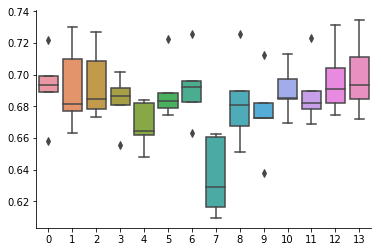

In [257]:
sns.boxplot(data=[three_output_results, no_preproc_results, sizes_conv_results, three_conv_results, one_conv_results, new_cnn38_three_output_wo_conv, three_output_avg_results, lower_dropout_results, middle_dropout_results, too_high_dropout_results, cv_spearmans1, cv_spearmans2, cv_spearmans3, cv_spearmans4])
sns.despine()


In [253]:
# last one: lower dropouts!
class CNN38LowerDropout(nn.Module):
    def __init__(self, input_size):
        super(CNN38LowerDropout, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels=4, out_channels=256, kernel_size=7, stride=1)  # boost this?
        self.conv2 = nn.Conv1d(
            in_channels=256, out_channels=1024, kernel_size=3)
        

        # 128 kernels, 30-3 => 27/2 => 13-3 => 10/2 => 5
        self._conv_output_dimension = 1024 * 2

        # hidden layers, additional_features, conv output

        self.pre_fc = nn.Linear(input_size, 256)
        self.fc1 = nn.Linear(256 + self._conv_output_dimension, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 1)

        self.apply(weights_init)

    def _forward_convolution(self, nuc_features):

        conv_input = nuc_features.view(-1, 30, 4).permute(0, 2, 1)

        conv1_output = F.relu(self.conv1(conv_input))
        conv1_output = F.dropout(conv1_output, 0.65, self.training)


        conv1_output = F.max_pool1d(conv1_output, 3)
        conv2_output = F.relu(self.conv2(conv1_output))
        conv2_output = F.dropout(conv2_output, 0.7, self.training)
        conv2_output = F.max_pool1d(conv2_output, 3)
        return conv2_output.view(-1, self._conv_output_dimension)

    def forward(self, x):
        nuc_features = x[:, :120]
        nuc_features.contiguous()

        convolution_output = self._forward_convolution(nuc_features)
        # two fully connected hidden layers

        pre_output = self.pre_fc(x)
        pre_output = F.dropout(pre_output, 0.5, self.training)

        out = F.relu(self.fc1(torch.cat(
            [pre_output, convolution_output], 1)))

        out = F.dropout(out, 0.6, self.training)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.7, self.training)

        return self.fc3(out)

In [ ]:
middle_dropout_results = cv_train_test(genes, normalized_features[:, order1_features], y, CNN38LowerDropout, 0.0003, 15002, folds=folds)


In [254]:
too_high_dropout_results = cv_train_test(genes, normalized_features[:, order1_features], y, CNN38LowerDropout, 0.0003, 15002, folds=folds)


/home/giali/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/giali/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/giali/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/giali/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/giali/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [192]:
lower_dropout_results

[0.66281328388998084,
 0.60957283457158995,
 0.61657055923480775,
 0.62898775158061748,
 0.66057111027951987]

In [ ]:

configs = [
    {'model_class': CNN38, 'feature_selector': order1_features, 'loss': nn.MSELoss(), 'learning_rate': 0.0003, 'epochs': 15000},
    ]
results = run_models(X_train, y_train, validation_fold, configs)
model = results[0][2]
predicted_labels = model(Variable(torch.from_numpy(X_test[:, order1_features]))).cpu().data.numpy()

print(spearmanr(predicted_labels, y_test)[0])
print(max(results[0][1]))

1
Experiment CNN38_0.0003_15000_MSELoss_160 already existed. Deleting.


In [7]:
print(spearmanr(predicted_labels, y_test)[0])
print(max(results[0][1]))

0.6332038254796858
0.6324884048198914


In [11]:
cv_result = cv_train_test(genes, normalized_features[:, order1_features], y, CNN38, 0.0003, 3000)

Experiment CNN38_0.0003_3000_MSELoss_cv|0 already existed. Deleting.


/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [262]:
cv_result

NameError: name 'cv_result' is not defined

In [12]:
rand_shuffle_results = train_predict_n_shuffles(CNN38, 
                                                normalized_features,
                                                order1_features,
                                                y,
                                                10,
                                                0.0003,
                                                6000)

Experiment CNN38_0.0003_6000_MSELoss_1600 already existed. Deleting.
Experiment CNN38_0.0003_6000_MSELoss_1601 already existed. Deleting.


KeyboardInterrupt: 